# Search Tool for InTeractions of CHemicals (STITCH) Data Processing

---

In [1]:
import collections

In [2]:
import json

In [23]:
import math

In [24]:
import matplotlib

In [25]:
matplotlib.use('Agg')

In [26]:
%matplotlib inline

In [27]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

In [2]:
import os

---

## Compound &rarr; Target (Inhibition)

### Processing *4932.actions.v4.0.tsv*:

**2015 December 2, 2016 March 18**

According to the README, the scores are "multiplied by 1000." From Kuhn, *et al.* (2014), high-confidence scores have a cutoff of 0.7. 

All entries in the "mode" column are of the following:
* activation
* binding
* catalysis
* inhibition
* reaction

Entries in the "action" column are either "activation" or "inhibition."

If "mode" entry is "activation" or "inhibition", then the corresponding entry in the "action" column is also "activation" or "inhibition", respectively. 

If "action" entry is "activation" or "inhibition", then the corresponding entry in the "mode" column (other than "activation" or "inhibition") is "binding."

<u>*NOTE*</u>: There exists compounds, such as acetylcholine, that BOTH inhibit and activate gene targets!

**2015 December 4, 2016 March 23**

It turns out that not all of the entries in the 1<sup>st</sup> column of *4932.actions.v4.0.tsv* are chemicals - some are chemicals while others are genes, and likewise for the entries in the 2<sup>nd</sup> column. Also note that all chemical prefixes begin with "CID", and all gene entries start with "4932."

How many chemicals are just inhibition? Are there any that have mixed actions, such as inhibiting some targets and activating others?

In [3]:
stitchfile = open(os.path.join('..', 'DataDownload', 'STITCH', '4932.actions.v4.0.tsv'))

In [4]:
header = stitchfile.readline().rstrip().split('\t')
actCol = header.index('action')
scoreCol = header.index('score')

In [5]:
chem2act = collections.defaultdict(set)

In [6]:
for line in stitchfile:
    tokens = line.rstrip().split('\t')
    if tokens[actCol] == 'inhibition' or tokens[actCol] == 'activation':
        if tokens[0][:3] == 'CID':
            chem2act[tokens[0]].add(tokens[actCol])
        else:
            chem2act[tokens[1]].add(tokens[actCol])

In [7]:
stitchfile.close()

In [8]:
len(chem2act)

3723

In [15]:
numOnlyInhibit = len( [chem for chem in chem2act if chem2act[chem] == {'inhibition'}] )
numOnlyActivate = len( [chem for chem in chem2act if chem2act[chem] == {'activation'}] )
print('The number of compounds that only inhibit is {:d}.'.format(numOnlyInhibit))
print('The number of compounds that only activate is {:d}.'.format(numOnlyActivate))

The number of compounds that only inhibit is 1732.
The number of compounds that only activate is 1156.


<u>Conclusion:</u> <s>So it looks like *any* chemical whose action is inhibition only has that as its sole action, e.g. it also doesn't activate.</s> So it appears that 835 compounds BOTH activate and inhibit. 

**2015 December 4, 8; 2016 March 8**

How many targets does each inhibiting chemical have?

*NOTE*: Only chemical-gene pairs with score &geq; 700 are considered.

*NOTE*: Every entry in the "item_id_a" and "item_id_b" columns starts with either "CID" or "4932.", as checked by a script reading line-by-line. 

In [11]:
chem2target = collections.defaultdict(set)

In [12]:
for line in stitchfile:
    tokens = line.rstrip().split('\t')
    if tokens[actCol] == 'inhibition' and float(tokens[scoreCol]) >= 700:
        if tokens[0][:3] == 'CID':
            chem = tokens[0]
            target = tokens[1][5:]
        else:
            chem = tokens[1]
            target = tokens[0][5:]
        chem2target[chem].add(target)
chem2target = dict((k,list(v)) for k,v in chem2target.items())

In [21]:
numTargets = np.array([len(chem2target[chem]) for chem in chem2target])

In [22]:
numTargets.size

806

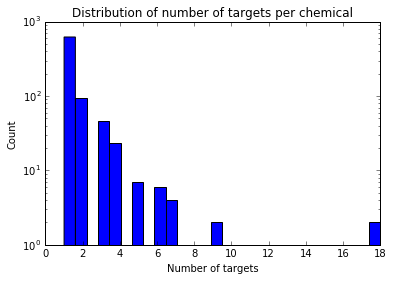

In [28]:
plt.hist(numTargets, bins=round(math.sqrt(numTargets.size)), log=True)
plt.xlabel('Number of targets')
plt.ylabel('Count')
plt.title('Distribution of number of targets per chemical')
plt.show()

In [29]:
np.unique(numTargets)

array([ 1,  2,  3,  4,  5,  6,  7,  9, 18])

In [33]:
savePath = os.path.join('..', 'DataProcessed', 'STITCH_cid2inhibit.json')

In [35]:
json.dump(chem2target, open(savePath, 'w'))

## Library for CID conversion

**2016 March 7-8**

"[PubChemPy](http://pubchempy.readthedocs.org/en/latest/) provides a way to interact with PubChem in Python. It allows chemical searches by name, substructure and similarity, chemical standardization, conversion between chemical file formats, depiction and retrieval of chemical properties."

Installed on 8 March:

    pip install pubchempy